In [1]:
import matplotlib.pyplot as plt
from image_util import I

## Filters
---


forward difference: $ f'(x) = \frac{f(x+h) - f(x)}{h}$

backward difference: $ f'(x) = \frac{f(x) - f(x-h)}{h}$

central difference: $f'(x)=\frac{f(x+h) - f(x-h)}{2h}$

### Padding

In [2]:
import copy

def pad_image(image, padding_height, padding_width):
    image = copy.deepcopy(image) # Avoid modifying the original image
    padded_image = []
    rows = len(image)
    cols = len(image[0])
    channels = len(image[0][0]) if type(image[0][0]) == list else 1 

    # Adjust channels
    zeros = [0] * channels
    if (channels == 1):
        zeros = 0

    # Pad rows at the top and bottom
    for i in range(padding_height):
        padded_image.append([zeros] * cols)
    for row in image:
        padded_image.append(row)
    for i in range(padding_height):
        padded_image.append([zeros] * cols)

    # Pad columns at the left and right
    for i in range(len(padded_image)):
        for j in range(padding_width):
            padded_image[i].insert(0, zeros)
        for j in range(padding_width):
            padded_image[i].append(zeros)

    return copy.deepcopy(padded_image)

### Convolution

In [3]:
import copy

def convolution(image, kernel):
    '''
    Performs convolution between an image and a kernel
    '''
    image = copy.deepcopy(image) # Avoid modifying the original image
    
    padding_height = len(kernel) // 2
    padding_width = len(kernel[0]) // 2
    
    # Pad the image
    padded_image = pad_image(image, padding_height, padding_width)
    
    # Create an output matrix with the same dimensions as the input image
    output = [[0] * len(image[0]) for i in range(len(image))]

    # Perform convolution
    image_height = len(image)
    image_width = len(image[0])
    kernel_height = len(kernel)
    kernel_width = len(kernel[0])
    
    for i in range(image_height):
        for j in range(image_width):
            for k in range(kernel_height):
                for l in range(kernel_width):
                    # kernel multiplication
                    if type(padded_image[i + k][j + l]) == list:
                        result = [x * kernel[k][l] for x in padded_image[i + k][j + l]]
                    else: # Assume it's a number
                        result = padded_image[i + k][j + l] * kernel[k][l]
                    output[i][j] = output[i][j] + int(result)
    return output

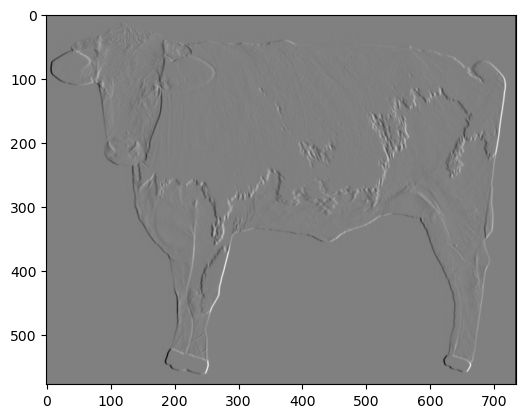

In [4]:
img = I.from_np(plt.imread('data/no_bg/img/sapi1.jpg')).image
gray = I.to_gray(img)
conv = convolution(gray, kernel=[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
I.show(conv, gray=True)

### Edge detection

In [5]:
def edge_detection(
    img: list,
    x_kernel: list = [[-1, 0, 1], 
                     [-2, 0, 2], 
                     [-1, 0, 1]],
    y_kernel: list = [[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]]
    ) -> list:
    '''
    detect edges in an image
    '''
    # convert image to grayscale
    if type(img[0][0]) != int and len(img[0][0]) == 3:
        img = I.to_gray(img)
    
    # create edge image
    edge = []
       
    # calculate the gradient in the x-direction and y-direction
    Ix = convolution(img, x_kernel)
    Iy = convolution(img, y_kernel)
        
    # loop through the image
    for i in range(len(img)):
        edge.append([])
        for j in range(len(img[0])):
            # remove edge pixels in image boundary
            if i == 0 or i == len(img) - 1 or j == 0 or j == len(img[0]) - 1:
                edge[i].append([0])
                continue
            # calculate the gradient magnitude
            edge[i].append([int((Ix[i][j]**2 + Iy[i][j]**2)**0.5)])
            
    return edge

In [89]:
import math

def canny_edge(img) -> list:
    # convert image to grayscale
    if type(img[0][0]) != int and len(img[0][0]) == 3:
        img = I.to_gray(img)
    
    # create edge image
    edge = []
    
    # calculate the gradient in the x-direction and y-direction
    x_kernel = [[-1, 0, 1], 
                [-2, 0, 2], 
                [-1, 0, 1]],
    y_kernel = [[-1, -2, -1],
                [0, 0, 0],
                [1, 2, 1]]
    
    Ix = convolution(img, x_kernel)
    Iy = convolution(img, y_kernel)
    
    # calculate the gradient magnitude
    Ixy = []
    for i in range(len(img)):
        Ixy.append([])
        for j in range(len(img[0])):
            Ixy[i].append(int((Ix[i][j]**2 + Iy[i][j]**2)**0.5))
            
    # calculate the gradient direction
    Itheta = []
    for i in range(len(img)):
        Itheta.append([])
        for j in range(len(img[0])):
            Itheta[i].append(int(math.atan2(Iy[i][j], Ix[i][j]) * 180 / math.pi))
            
    # non-maximum suppression
    Non_Max = []
    for i in range(len(img)):
        for j in range(len(img[0])):
            q, r = 255, 255
            # angle 0
            if (0 <= Itheta[i][j] < 22.5) or (157.5 <= Itheta[i][j] <= 180):
                q = Ixy[i][j+1]
                r = Ixy[i][j-1]
            # angle 45
            elif 22.5 <= Itheta[i][j] < 67.5:
                q = Ixy[i+1][j-1]
                r = Ixy[i-1][j+1]
            # angle 90
            elif 67.5 <= Itheta[i][j] < 112.5:
                q = Ixy[i+1][j]
                r = Ixy[i-1][j]
            # angle 135
            elif 112.5 <= Itheta[i][j] < 157.5:
                q = Ixy[i-1][j-1]
                r = Ixy[i+1][j+1]
                
            # non-maximum suppression
            if (Ixy[i][j] >= q) and (Ixy[i][j] >= r):
                Non_Max = Ixy[i][j]
            else:
                Non_Max[i][j] = 0
                
    return Non_Max
    # double threshold
    

In [90]:
img = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
gray = I.to_gray(img)
edge = canny_edge(gray)
# set threshold
# edge = edge_threshold(edge, threshold=100)

I.show(edge, gray=True)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [6]:
def edge_threshold(edge: list, threshold: int = 100) -> list:
    '''
    threshold the edge image
    '''
    # create a copy of the edge image
    edge = copy.deepcopy(edge)
    
    # loop through the image
    for i in range(len(edge)):
        for j in range(len(edge[0])):
            # threshold the pixel
            if edge[i][j][0] > threshold:
                edge[i][j] = 255
            else:
                edge[i][j] = 0
                
    return edge

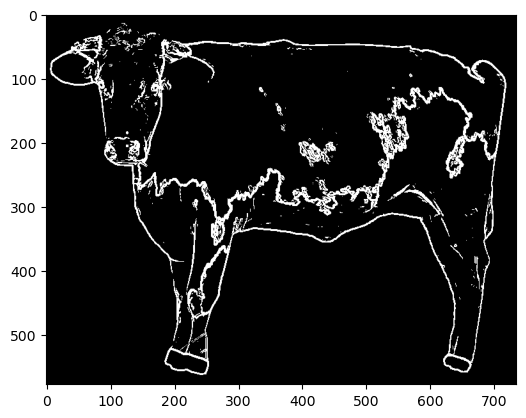

In [7]:
img = I.from_np(plt.imread('data/no_bg/img/sapi1.jpg')).image
edge = edge_detection(img)
# set threshold
edge = edge_threshold(edge, threshold=100)

I.show(edge, gray=True)

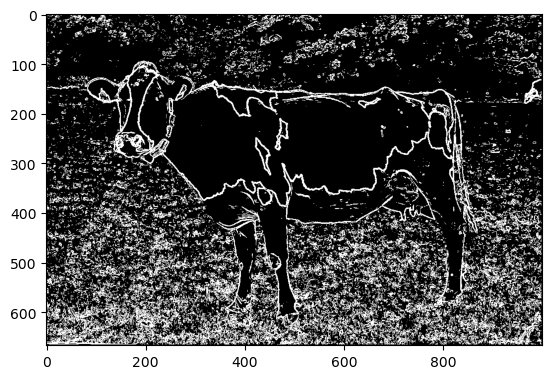

In [8]:
bg = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
edge = edge_detection(bg)
edge = edge_threshold(edge, threshold=100)
I.show(edge, gray=True)

### Median Filter

In [9]:
def median_filter(gray_img, mask=3):
    """
    :param gray_img: gray image
    :param mask: mask size
    :return: image with median filter
    """
    # set image borders
    bd = int(mask / 2)
    
    row = len(gray_img)
    col = len(gray_img[0])
    
    # copy image size
    median_img = [[0] * col for i in range(row)]
    
    for i in range(bd, row - bd):
        for j in range(bd, col - bd):
            # get mask according with mask
            kernel = [[gray_img[i - bd + k][j - bd + l] for l in range(mask)] for k in range(mask)]
            kernel = I.flatten(kernel)
            sorted_list = sorted(kernel)
            # calculate mask median
            median = sorted_list[int(len(sorted_list) / 2)]
            median_img[i][j] = median
    return median_img

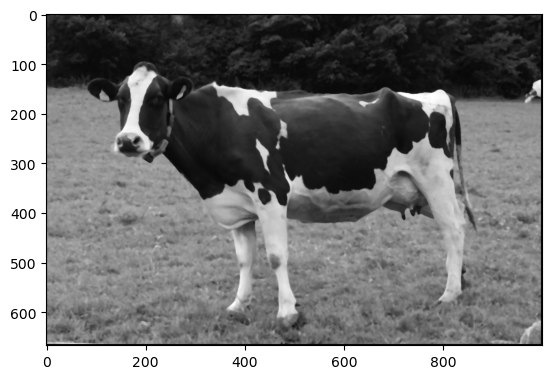

In [10]:
img = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
gray = I.to_gray(img)
median = median_filter(gray, mask=5)
I.show(median, gray=True)

### Gaussian Filter

In [11]:
import math

def generate_gaussian_kernel(size, sigma):
    kernel = [[0.0] * size for _ in range(size)]
    center = size // 2
    total = 0.0

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            exponent = -(x ** 2 + y ** 2) / (2 * sigma ** 2)
            kernel[i][j] = math.exp(exponent)
            total += kernel[i][j]

    # Normalize the kernel
    for i in range(size):
        for j in range(size):
            kernel[i][j] /= total
            kernel[i][j] = round(kernel[i][j], 2)

    return kernel

In [12]:
gaussian_kernel = generate_gaussian_kernel(5, 2)
gaussian_kernel

[[0.02, 0.03, 0.04, 0.03, 0.02],
 [0.03, 0.05, 0.06, 0.05, 0.03],
 [0.04, 0.06, 0.06, 0.06, 0.04],
 [0.03, 0.05, 0.06, 0.05, 0.03],
 [0.02, 0.03, 0.04, 0.03, 0.02]]

In [13]:
blurred_img = convolution(gray, gaussian_kernel)

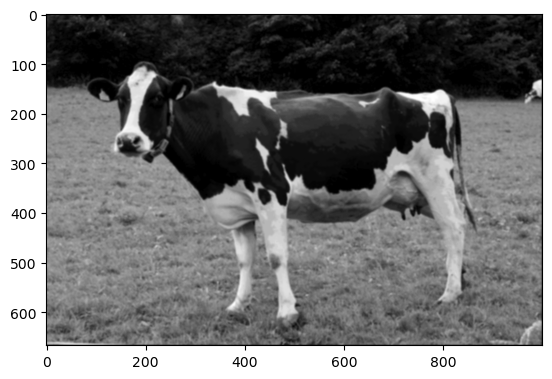

In [14]:
I.show(blurred_img, gray=True)

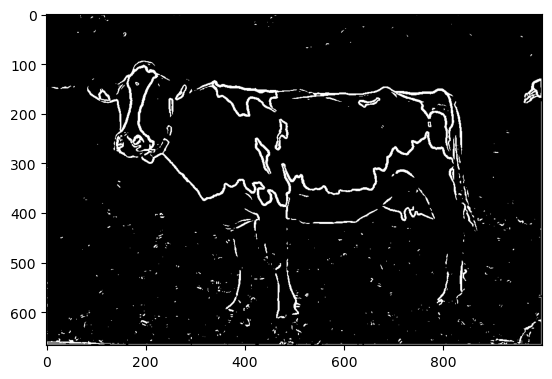

In [15]:
edge = edge_detection(blurred_img)
edge = edge_threshold(edge, threshold=110)
I.show(edge, gray=True)

### Find Connected Components

In [80]:
import copy

def connected_components(binary_image, min_size=100):
    '''
    Find and label connected components in a binary image
    input: binary image (2D array)
    output: labeled image (2D array), dictionary of component sizes, number of components
    '''
    binary_image = copy.deepcopy(binary_image) # Make sure we don't overwrite the original image
    height, width = len(binary_image), len(binary_image[0])
    label_matrix = [[0] * width for _ in range(height)]  # Initialize empty label matrix

    label = 0  # Start label
    label_dict = {}  # Keep track of which label corresponds to which connected component
    component_sizes = {}  # Keep track of component sizes
    
    # First pass
    for i in range(height):
        for j in range(width):            
            if binary_image[i][j] == 0: # background pixel
                continue
            
            if i == 0 and j == 0: # first pixel
                continue
            
            # check neighbors (8-connectivity)
            neighbors = [binary_image[i][j-1], 
                         binary_image[i-1][j-1], 
                         binary_image[i-1][j],
                         binary_image[i-1][j+1]]
            
            # check neighbors (4-connectivity)
            # neighbors = [padded_image[i][j-1],
            #              padded_image[i-1][j]]

            if sum(neighbors) == 0: # no neighbors
                label += 1 # increment label
                label_dict[label] = [label] # create new label
                label_matrix[i][j] = label # assign label to pixel
            else:
                matrix_neighbors = [label_matrix[i][j-1], 
                                 label_matrix[i-1][j-1], 
                                 label_matrix[i-1][j],
                                 label_matrix[i-1][j+1]]
                min_label = min(num for num in matrix_neighbors if num > 0) # get min label from neighbors
                
                label_matrix[i][j] = min_label # assign min label to pixel
                label_dict[label_matrix[i][j]].append(min_label) # add label to label_dict
                
    # Second pass
    for i in range(height):
        for j in range(width):
            if label_matrix[i][j] == 0:
                continue
            
            label_matrix[i][j] = min(label_dict[label_matrix[i][j]]) # assign min label to pixel
            component_sizes[label_matrix[i][j]] = component_sizes.get(label_matrix[i][j], 0) + 1  # increment component size
    
    # Remove small components
    for i in range(height):
        for j in range(width):
            label = label_matrix[i][j]
            if label != 0 and component_sizes[label] < min_size:
                label_matrix[i][j] = 0
    
    return label_matrix, component_sizes, label_dict

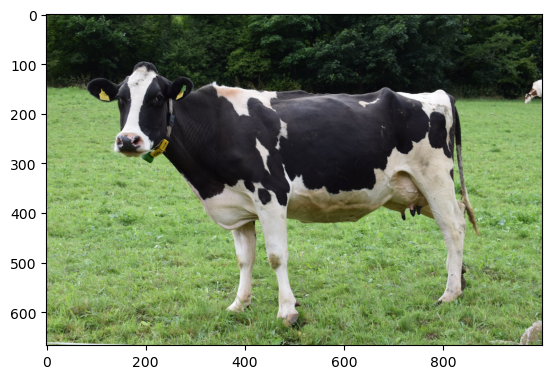

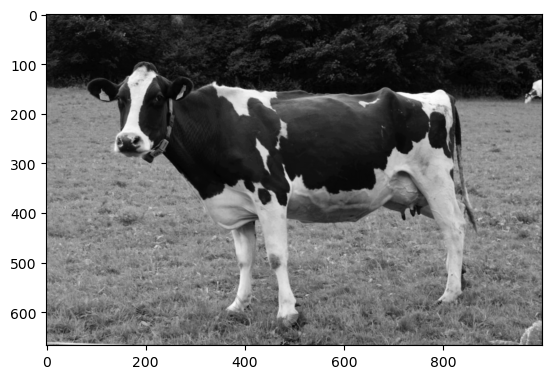

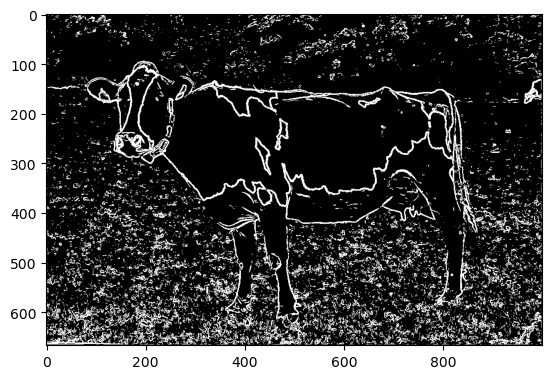

In [77]:
img = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
# img = I.bl_resize(original_img=img, new_h=200, new_w=200)
I.show(img)

gray = I.to_gray(img)
gaussian_kernel = generate_gaussian_kernel(3, 0.6)
blurred_img = convolution(gray, gaussian_kernel)
I.show(blurred_img, gray=True)

edge = edge_detection(blurred_img)
edge = edge_threshold(edge, threshold=100)
I.show(edge, gray=True)

In [81]:
# normalize edges to 0 and 1
norm = [[0 if i == 0 else 1 for i in j] for j in edge]
label_matrix, component_sizes, label_dict = connected_components(binary_image=norm)

{1: 2, 2: 4, 3: 50, 4: 3, 5: 100, 6: 1, 7: 9, 8: 2, 9: 9, 10: 4, 11: 9, 12: 2, 13: 2, 14: 36, 15: 3, 16: 29, 17: 14, 18: 8, 19: 30, 20: 10, 21: 6, 22: 1, 23: 3, 24: 1, 25: 1, 26: 6, 27: 3, 28: 7, 29: 16, 30: 8, 31: 1, 32: 1, 33: 15, 34: 14, 35: 11, 36: 15, 37: 5, 38: 3, 39: 3, 40: 3, 41: 3, 42: 4, 43: 1, 44: 1, 45: 7, 46: 3, 47: 11, 48: 2, 49: 13, 50: 1, 51: 1, 52: 2, 53: 2, 54: 4, 55: 2, 56: 2, 57: 22, 58: 1, 59: 8, 60: 1, 61: 3, 62: 8, 63: 38, 64: 2, 65: 7, 66: 9, 67: 2, 68: 7, 69: 2, 70: 9, 71: 4, 72: 4, 73: 2, 74: 3, 75: 1, 76: 2, 77: 6, 78: 5, 79: 14, 80: 1, 81: 6, 82: 4, 83: 4, 84: 38, 85: 10, 86: 4, 87: 5, 88: 6, 89: 1, 90: 1, 91: 2, 92: 5, 93: 3, 94: 16, 95: 2, 96: 2, 97: 3, 98: 11, 99: 1, 100: 2, 101: 2, 102: 1, 103: 1, 104: 6, 105: 11, 106: 2, 107: 1, 108: 10, 109: 5, 110: 2, 111: 3, 112: 34, 113: 1, 114: 7, 115: 2, 116: 3, 117: 3, 118: 1, 119: 1, 120: 4, 121: 6, 122: 3, 123: 6, 124: 1, 125: 1, 126: 4, 127: 1, 128: 2, 129: 10, 130: 2, 131: 1, 132: 3, 133: 2, 134: 2, 135: 5, 1

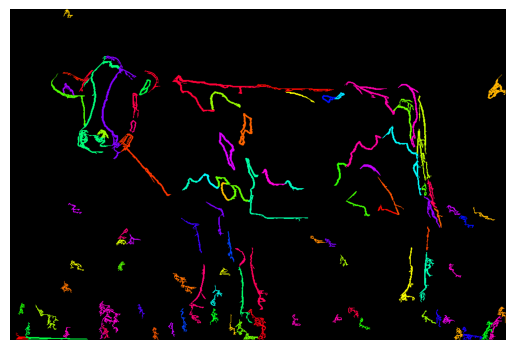

In [82]:
import matplotlib.pyplot as plt
import random
import colorsys

def plot_label_matrix(label_matrix):
    height, width = len(label_matrix), len(label_matrix[0])
    unique_labels = set(sum(label_matrix, [])) - {0}  # Get unique labels excluding background (label 0)
    num_labels = len(unique_labels)
    
    # Generate random colors for each label
    label_colors = {}
    for label in unique_labels:
        # random hue
        hue = random.random()
        hsv = (hue, 1, 1)
        rgb = colorsys.hsv_to_rgb(*hsv)
        label_colors[label] = rgb
    
    # Create an RGB image based on the label matrix
    rgb_image = [[label_colors[label] if label in label_colors else (0, 0, 0) for label in row] for row in label_matrix]
    
    # Display the labeled image
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

plot_label_matrix(connected)

## Implement
---